This uses the pollution.csv file to predict the 'pollution' column.

Though it is a regression problem, but gives you an example on how to prepare dataset involving multiple features and multiple timesteps.

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from datetime import datetime

## Data Preparation

In [3]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
# Data cleaning
dataset = dataset.drop(columns = ['No'])
dataset.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [6]:
dataset.tail()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0
2014-12-31 23:00:00,12.0,-21,-3.0,1034.0,NW,249.85,0,0


In [7]:
dataset.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [8]:
# check missing values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  41757 non-null  float64
 1   dew        43824 non-null  int64  
 2   temp       43824 non-null  float64
 3   press      43824 non-null  float64
 4   wnd_dir    43824 non-null  object 
 5   wnd_spd    43824 non-null  float64
 6   snow       43824 non-null  int64  
 7   rain       43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [0]:
# mark all NA values with median
dataset['pollution'].fillna(dataset['pollution'].median(), inplace=True)

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43824 non-null  float64
 1   dew        43824 non-null  int64  
 2   temp       43824 non-null  float64
 3   press      43824 non-null  float64
 4   wnd_dir    43824 non-null  object 
 5   wnd_spd    43824 non-null  float64
 6   snow       43824 non-null  int64  
 7   rain       43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [0]:
# integer encode wnd_dir column (index 4 column)
le = LabelEncoder()
dataset['wnd_dir'] = le.fit_transform(dataset['wnd_dir'])

In [12]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,72.0,-21,-11.0,1021.0,1,1.79,0,0
2010-01-01 01:00:00,72.0,-21,-12.0,1020.0,1,4.92,0,0
2010-01-01 02:00:00,72.0,-21,-11.0,1019.0,1,6.71,0,0
2010-01-01 03:00:00,72.0,-21,-14.0,1019.0,1,9.84,0,0
2010-01-01 04:00:00,72.0,-20,-12.0,1018.0,1,12.97,0,0


In [0]:
# # drop the first 24 hours
# dataset = dataset[24:]
# # summarize first 5 rows
# print(dataset.head(5))

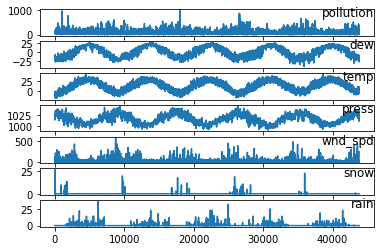

In [14]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column

plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

## Baseline

#### Persist the last observed value for each series.

In [0]:
pollution = dataset['pollution']

In [16]:
baseline_rmse = (mean_squared_error(pollution[:-1], pollution[1:])) ** 0.5
baseline_rmse

25.879218103946528

## Multivariate (Feature) Single Timestep LSTM Forecast Model

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [18]:
dataset.shape

(43824, 8)

In [19]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,72.0,-21,-11.0,1021.0,1,1.79,0,0
2010-01-01 01:00:00,72.0,-21,-12.0,1020.0,1,4.92,0,0
2010-01-01 02:00:00,72.0,-21,-11.0,1019.0,1,6.71,0,0
2010-01-01 03:00:00,72.0,-21,-14.0,1019.0,1,9.84,0,0
2010-01-01 04:00:00,72.0,-20,-12.0,1018.0,1,12.97,0,0


In [0]:
# frame as supervised learning
TIMESTEPS = 1
FEATURES = 8
reframed = series_to_supervised(dataset.values, TIMESTEPS, 1)

In [21]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,72.0,-21.0,-11.0,1021.0,1.0,1.79,0.0,0.0,72.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0
2,72.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,72.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0
3,72.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0
4,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0
5,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0


In [22]:
reframed.shape

(43823, 16)

In [0]:
# split input and output
x = reframed.iloc[:, :-FEATURES]
y = reframed.iloc[:, -8]

In [24]:
x.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
1,72.0,-21.0,-11.0,1021.0,1.0,1.79,0.0,0.0
2,72.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0
3,72.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0
4,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0
5,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0


In [25]:
y

1        72.0
2        72.0
3        72.0
4        72.0
5        72.0
         ... 
43819     8.0
43820    10.0
43821    10.0
43822     8.0
43823    12.0
Name: var1(t), Length: 43823, dtype: float64

In [0]:
# Split train and test (first 70% as train, last 30% as test)
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    shuffle = False,
                                                    test_size = 0.3)

In [27]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((30676, 8), (30676,), (13147, 8), (13147,))

In [0]:
# normalize features
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [0]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], TIMESTEPS, FEATURES))
x_test = x_test.reshape((x_test.shape[0], TIMESTEPS, FEATURES))

In [30]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((30676, 1, 8), (30676,), (13147, 1, 8), (13147,))

In [0]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(TIMESTEPS, FEATURES)))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

In [0]:
model.compile(loss='mse', optimizer='adam')

In [33]:
# fit network
from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(x_train, y_train, 
                    epochs=50, 
                    validation_data=(x_test, y_test), 
                    shuffle=False,
                    callbacks = [
                                 EarlyStopping(
                                     patience = 5,
                                     monitor = 'val_loss',
                                     restore_best_weights = True
                                 )
                    ])

Epoch 1/50
959/959 [==============================] - 4s 4ms/step - loss: 8309.7959 - val_loss: 6450.0728
Epoch 2/50
959/959 [==============================] - 3s 3ms/step - loss: 5009.7148 - val_loss: 3607.0461
Epoch 3/50
959/959 [==============================] - 3s 3ms/step - loss: 1789.9030 - val_loss: 1370.2467
Epoch 4/50
959/959 [==============================] - 3s 3ms/step - loss: 892.2493 - val_loss: 859.5330
Epoch 5/50
959/959 [==============================] - 3s 3ms/step - loss: 789.7588 - val_loss: 693.3880
Epoch 6/50
959/959 [==============================] - 3s 3ms/step - loss: 743.2933 - val_loss: 628.1848
Epoch 7/50
959/959 [==============================] - 3s 3ms/step - loss: 722.6583 - val_loss: 592.3141
Epoch 8/50
959/959 [==============================] - 3s 3ms/step - loss: 713.4100 - val_loss: 563.9985
Epoch 9/50
959/959 [==============================] - 3s 3ms/step - loss: 709.1445 - val_loss: 547.0186
Epoch 10/50
959/959 [==============================] - 3s 

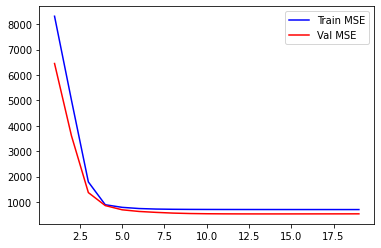

In [34]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs, loss,'b',label='Train MSE')
plt.plot(epochs, val_loss,'r',label='Val MSE')
plt.legend()
plt.show()

In [35]:
# Evaluate with test set
model.evaluate(x_test, y_test)

411/411 [==============================] - 1s 1ms/step - loss: 531.4756


531.4756469726562

In [0]:
# make a prediction
y_pred = model.predict(x_test)

In [37]:
# calculate RMSE
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.058


## Train On Multivariate (Feature) & Multi Timesteps Example

Everything is the same, except that the constant TIMESTEPS is changed when calling the reframing function

In [0]:
# frame as supervised learning
TIMESTEPS = 6
FEATURES = 8
reframed = series_to_supervised(dataset.values, TIMESTEPS, 1)

In [39]:
reframed.head()

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
6,72.0,-21.0,-11.0,1021.0,1.0,1.79,0.0,0.0,72.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,72.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0
7,72.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,72.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,21.02,0.0,0.0
8,72.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,21.02,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,24.15,0.0,0.0
9,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,21.02,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,24.15,0.0,0.0,72.0,-20.0,-8.0,1017.0,1.0,27.28,0.0,0.0
10,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,21.02,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,24.15,0.0,0.0,72.0,-20.0,-8.0,1017.0,1.0,27.28,0.0,0.0,72.0,-19.0,-7.0,1017.0,1.0,31.30,0.0,0.0


In [40]:
reframed.shape

(43818, 56)

In [0]:
# split input and output
x = reframed.iloc[:, :-FEATURES]
y = reframed.iloc[:, -8]

In [42]:
x.head()

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
6,72.0,-21.0,-11.0,1021.0,1.0,1.79,0.0,0.0,72.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,72.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0
7,72.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,72.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0
8,72.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,21.02,0.0,0.0
9,72.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,21.02,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,24.15,0.0,0.0
10,72.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,72.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,21.02,0.0,0.0,72.0,-19.0,-9.0,1017.0,1.0,24.15,0.0,0.0,72.0,-20.0,-8.0,1017.0,1.0,27.28,0.0,0.0


In [43]:
y

6        72.0
7        72.0
8        72.0
9        72.0
10       72.0
         ... 
43819     8.0
43820    10.0
43821    10.0
43822     8.0
43823    12.0
Name: var1(t), Length: 43818, dtype: float64

In [0]:
# Split train and test (first 70% as train, last 30% as test)
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    shuffle = False,
                                                    test_size = 0.3)

In [45]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((30672, 48), (30672,), (13146, 48), (13146,))

In [0]:
# normalize features
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [0]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], TIMESTEPS, FEATURES))
x_test = x_test.reshape((x_test.shape[0], TIMESTEPS, FEATURES))

In [48]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((30672, 6, 8), (30672,), (13146, 6, 8), (13146,))

In [0]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(TIMESTEPS, FEATURES)))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

In [0]:
model.compile(loss='mse', optimizer='adam')

In [51]:
# fit network
from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(x_train, y_train, 
                    epochs=50, 
                    validation_data=(x_test, y_test), 
                    shuffle=False,
                    callbacks = [
                                 EarlyStopping(
                                     patience = 5,
                                     monitor = 'val_loss',
                                     restore_best_weights = True
                                 )
                    ])

Epoch 1/50
959/959 [==============================] - 7s 7ms/step - loss: 7492.2979 - val_loss: 4565.0039
Epoch 2/50
959/959 [==============================] - 7s 7ms/step - loss: 2940.8054 - val_loss: 2828.8577
Epoch 3/50
959/959 [==============================] - 6s 7ms/step - loss: 2216.5156 - val_loss: 2304.1797
Epoch 4/50
959/959 [==============================] - 7s 7ms/step - loss: 1895.1768 - val_loss: 1910.5743
Epoch 5/50
959/959 [==============================] - 7s 7ms/step - loss: 1610.4325 - val_loss: 1508.1888
Epoch 6/50
959/959 [==============================] - 7s 7ms/step - loss: 1332.1316 - val_loss: 1097.1366
Epoch 7/50
959/959 [==============================] - 7s 7ms/step - loss: 1103.7656 - val_loss: 819.5693
Epoch 8/50
959/959 [==============================] - 7s 7ms/step - loss: 932.1782 - val_loss: 650.7705
Epoch 9/50
959/959 [==============================] - 6s 7ms/step - loss: 827.3687 - val_loss: 607.7084
Epoch 10/50
959/959 [==============================

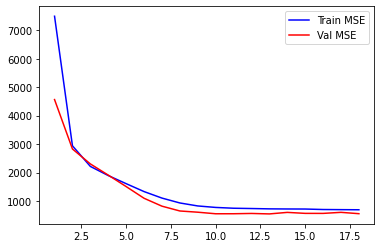

In [52]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs, loss,'b',label='Train MSE')
plt.plot(epochs, val_loss,'r',label='Val MSE')
plt.legend()
plt.show()

In [53]:
# Evaluate with test set
model.evaluate(x_test, y_test)

411/411 [==============================] - 1s 2ms/step - loss: 547.5724


547.5723876953125

In [0]:
# make a prediction
y_pred = model.predict(x_test)

In [55]:
# calculate RMSE
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.405


Using multi timesteps does not show much advantage in this case. Can consider tune the number of timesteps. Or it might be that for this problem, one timestep is enough and the best.